In [6]:
import os

import pandas as pd
import numpy as np
from pathlib import Path
from colorama import Fore, Style # 文字に色を付けるライブラリ
# display, HTML のインポート
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [7]:
BASE_PATH = Path.cwd()
DATA_PATH = BASE_PATH / "data"

train = pd.read_csv(DATA_PATH / "train.csv")
test = pd.read_csv(DATA_PATH / "test.csv")

In [8]:
MAX_INVESTMENT = 2
MIN_INVESTMENT = 0

In [ ]:
from python.metrics import score

score_list_dict = {}
def cross_validate(allocation_model, label="", min_train_size=1500, test_size=180):
    """
    時系列を考慮した交差検証を行う
    検証インデックス：
    range(len(train) - test_size, min_train_size, - test_size)
    例えば、trainデータが2000行、test_size=120、min_train_size=1500の場合、
    検証用のインデックスは：
    range(2000 - 120, 1500, -120) = range(1880, 1500, -120)
    = (1880, 1760, 1640, 1520)
    となり、各foldで未来のデータを使用せずに評価することができる．
    trainサイズはfoldが進む毎に減少し，min_train_sizeに達したら終了する．
    減少させているのは未来リークを防ぐため．
    """
    oof = np.full(len(train), np.nan)
    score_list = []
    intermediate_res = []

    for fold, test_start in enumerate(
        range(len(train) - test_size, min_train_size, -test_size)
    ):
        print(Fore.CYAN + f"=== Fold {fold} Test start at {test_start} ===" + Style.RESET_ALL)
        # 1. データ分割
        train_fold = train.iloc[:test_start]
        test_fold = train.iloc[test_start : test_start + test_size]

        # 特徴カラム選択
        X_train = train_fold.drop(
            [
                "date_id",
                "forward_returns",
                "risk_free_rate",
                "market_forward_excess_returns",
            ],
            axis=1,
        )
        y_train = train_fold["forward_returns"]
        X_test = test_fold.drop(
            [
                "date_id",
                "forward_returns",
                "risk_free_rate",
                "market_forward_excess_returns",
            ],
            axis=1,
        )
        y_test = test_fold["forward_returns"]

        # 評価用のデータ保存
        solution = pd.DataFrame(
            {
                "forward_returns": test_fold["forward_returns"].values,
                "risk_free_rate": test_fold["risk_free_rate"].values,
            }
        ).reset_index(drop=True)

        # 2. モデル学習
        allocation_model.fit(X_train, y_train)

        # 3. 予測
        y_pred = allocation_model.predict(X_test)
        allocation_list = np.clip(y_pred, 0, 2)  # 投資比率は0から2の間にクリップ

        # 4. 評価
        submission = pd.DataFrame({"prediction": allocation_list}).reset_index(drop=True)
        validation_score, intermediate_res = score(
            solution, submission, "", intermediate_res
        )

        vol_penalty = intermediate_res[-1][3]   # ボラティリティペナルティ
        return_penalty = intermediate_res[-1][4]# リターンペナルティ

        if fold < 5 or 30 <= fold:
            display(HTML(f"<p  style = 'color: orange'>train(:{test_start:4}) test({test_start:4}:{test_start+test_size:4})<br>val_score: {validation_score:6.3f} {vol_penalty=:.2f} {return_penalty=:.2f}</p>"))
        else:
            print(Fore.YELLOW + f"score : {validation_score:6.3f}" + Style.RESET_ALL)

        oof[test_start:test_start + test_size] = allocation_list
        score_list.append(validation_score)

    # 集計表示
    display(HTML('<h2 style="text-align:center;color:orange">======== Scoring ========</h2>'))
    avg_validation_score = float(np.nanmean(score_list)) if len(score_list) else np.nan
    print(f"{label} Average Validation Score: {avg_validation_score:.6f}")

    # 全体スコア（インデックス揃え）
    mask = np.isfinite(oof)
    solution_all = train.loc[mask, ['forward_returns','risk_free_rate']].reset_index(drop=True)
    submission_all = pd.DataFrame({'prediction': oof[mask]}).reset_index(drop=True)
    overall_score, intermediate_res = score(solution_all, submission_all, '', intermediate_res)

    if intermediate_res:
        vol_penalty = intermediate_res[-1][3]
        return_penalty = intermediate_res[-1][4]
    else:
        vol_penalty = return_penalty = np.nan
    print(f"{label} Overall Validation Score: {overall_score:.6f} vol_penalty={vol_penalty:.2f} return_penalty={return_penalty:.2f}")
    score_list_dict[label] = score_list
    # 1回目のfoldのスコアを示す
    if score_list:
        print(f"{label} First(Test) Fold Validation Score: {score_list[0]:.6f}")

    # 分布可視化
    vals = oof[mask]
    if len(vals):
        vmin, vmax = float(np.min(vals)), float(np.max(vals))
        if vmin == vmax:
            vmax = vmin + 1e-6
        bins = np.linspace(vmin, vmax, 50)
        plt.figure(figsize=(6, 2))
        plt.hist(vals, bins=bins, density=False, color='c', edgecolor='k', linewidth=0.5)
        plt.title(f'Allocation histogram of {label}')
        plt.gca().get_yaxis().set_visible(False)
        plt.xlim(vmin, vmax)
        plt.show()

    print(f"Range of predictions: [{vmin:.6f}, {vmax:.6f}]")


=== Fold 0 Test start at 8810 ===


=== Fold 1 Test start at 8630 ===


=== Fold 2 Test start at 8450 ===


=== Fold 3 Test start at 8270 ===


=== Fold 4 Test start at 8090 ===


=== Fold 5 Test start at 7910 ===
=== Fold 6 Test start at 7730 ===
=== Fold 7 Test start at 7550 ===
=== Fold 8 Test start at 7370 ===
=== Fold 9 Test start at 7190 ===
=== Fold 10 Test start at 7010 ===
=== Fold 11 Test start at 6830 ===
=== Fold 12 Test start at 6650 ===
=== Fold 13 Test start at 6470 ===
=== Fold 14 Test start at 6290 ===
=== Fold 15 Test start at 6110 ===
=== Fold 16 Test start at 5930 ===
=== Fold 17 Test start at 5750 ===
=== Fold 18 Test start at 5570 ===
=== Fold 19 Test start at 5390 ===
=== Fold 20 Test start at 5210 ===
=== Fold 21 Test start at 5030 ===
=== Fold 22 Test start at 4850 ===
=== Fold 23 Test start at 4670 ===
=== Fold 24 Test start at 4490 ===
=== Fold 25 Test start at 4310 ===
=== Fold 26 Test start at 4130 ===
=== Fold 27 Test start at 3950 ===
=== Fold 28 Test start at 3770 ===
=== Fold 29 Test start at 3590 ===
=== Fold 30 Test start at 3410 ===


=== Fold 31 Test start at 3230 ===


=== Fold 32 Test start at 3050 ===


=== Fold 33 Test start at 2870 ===


=== Fold 34 Test start at 2690 ===


=== Fold 35 Test start at 2510 ===


=== Fold 36 Test start at 2330 ===


=== Fold 37 Test start at 2150 ===


=== Fold 38 Test start at 1970 ===


=== Fold 39 Test start at 1790 ===


=== Fold 40 Test start at 1610 ===


Cheat Model Average Validation Score: 3.669409
Cheat Model Overall Validation Score: 3.636027 vol_penalty=1.00 return_penalty=1.39
Cheat Model First(Test) Fold Validation Score: 3.602988


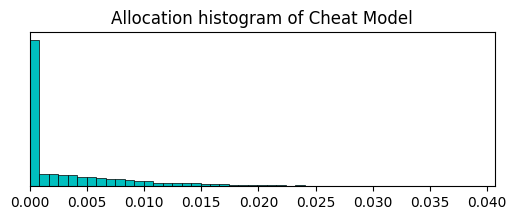

Range of predictions: [0.000000, 0.040661]


In [14]:
# 真値をそのまま持ってくるチートモデルを定義し，スコアの最大値を確認する
class CheatModel:
    def fit(self, X, y):
        pass

    def predict(self, X):
        indices = X.index
        try:
            true_returns = train.loc[indices, "forward_returns"].to_numpy()
        except KeyError:
            raise KeyError("CheatModel can only be used on training data.")

        return true_returns
    
cross_validate(CheatModel(), label="Cheat Model")

=== Fold 0 Test start at 8810 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21575
[LightGBM] [Info] Number of data points in the train set: 8810, number of used features: 94
[LightGBM] [Info] Start training from score 0.000468


=== Fold 1 Test start at 8630 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21573
[LightGBM] [Info] Number of data points in the train set: 8630, number of used features: 94
[LightGBM] [Info] Start training from score 0.000460


=== Fold 2 Test start at 8450 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21575
[LightGBM] [Info] Number of data points in the train set: 8450, number of used features: 94
[LightGBM] [Info] Start training from score 0.000453


=== Fold 3 Test start at 8270 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21574
[LightGBM] [Info] Number of data points in the train set: 8270, number of used features: 94
[LightGBM] [Info] Start training from score 0.000440


=== Fold 4 Test start at 8090 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21569
[LightGBM] [Info] Number of data points in the train set: 8090, number of used features: 94
[LightGBM] [Info] Start training from score 0.000468


=== Fold 5 Test start at 7910 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21568
[LightGBM] [Info] Number of data points in the train set: 7910, number of used features: 94
[LightGBM] [Info] Start training from score 0.000465
=== Fold 6 Test start at 7730 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21566
[LightGBM] [Info] Number of data points in the train set: 7730, number of used features: 94
[LightGBM] [Info] Start training from score 0.000448
=== Fold 7 Test start at 7550 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21508
[LightGBM] [Info]

=== Fold 31 Test start at 3230 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16840
[LightGBM] [Info] Number of data points in the train set: 3230, number of used features: 83
[LightGBM] [Info] Start training from score 0.000411


=== Fold 32 Test start at 3050 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16764
[LightGBM] [Info] Number of data points in the train set: 3050, number of used features: 83
[LightGBM] [Info] Start training from score 0.000508


=== Fold 33 Test start at 2870 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16753
[LightGBM] [Info] Number of data points in the train set: 2870, number of used features: 82
[LightGBM] [Info] Start training from score 0.000571


=== Fold 34 Test start at 2690 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16710
[LightGBM] [Info] Number of data points in the train set: 2690, number of used features: 82
[LightGBM] [Info] Start training from score 0.000672


=== Fold 35 Test start at 2510 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16510
[LightGBM] [Info] Number of data points in the train set: 2510, number of used features: 82
[LightGBM] [Info] Start training from score 0.000688


=== Fold 36 Test start at 2330 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16156
[LightGBM] [Info] Number of data points in the train set: 2330, number of used features: 82
[LightGBM] [Info] Start training from score 0.000685


=== Fold 37 Test start at 2150 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14744
[LightGBM] [Info] Number of data points in the train set: 2150, number of used features: 82
[LightGBM] [Info] Start training from score 0.000685


=== Fold 38 Test start at 1970 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13765
[LightGBM] [Info] Number of data points in the train set: 1970, number of used features: 81
[LightGBM] [Info] Start training from score 0.000635


=== Fold 39 Test start at 1790 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13090
[LightGBM] [Info] Number of data points in the train set: 1790, number of used features: 80
[LightGBM] [Info] Start training from score 0.000562


=== Fold 40 Test start at 1610 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10124
[LightGBM] [Info] Number of data points in the train set: 1610, number of used features: 77
[LightGBM] [Info] Start training from score 0.000519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

LightGBM Model Average Validation Score: 0.435870
LightGBM Model Overall Validation Score: 0.227294 vol_penalty=1.00 return_penalty=1.59
LightGBM Model First(Test) Fold Validation Score: 0.096097


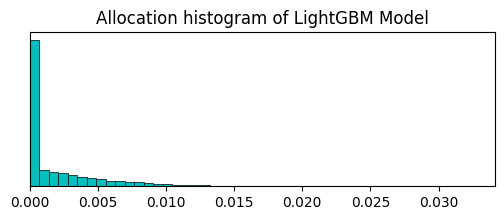

Range of predictions: [0.000000, 0.034116]


In [15]:
# 単純なLightGBMモデルで試す
import lightgbm as lgb
allocation_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
)

cross_validate(allocation_model, label="LightGBM Model")

=== Fold 0 Test start at 8810 ===


=== Fold 1 Test start at 8630 ===


=== Fold 2 Test start at 8450 ===


=== Fold 3 Test start at 8270 ===


=== Fold 4 Test start at 8090 ===


=== Fold 5 Test start at 7910 ===
=== Fold 6 Test start at 7730 ===
=== Fold 7 Test start at 7550 ===
=== Fold 8 Test start at 7370 ===
=== Fold 9 Test start at 7190 ===
=== Fold 10 Test start at 7010 ===
=== Fold 11 Test start at 6830 ===
=== Fold 12 Test start at 6650 ===
=== Fold 13 Test start at 6470 ===
=== Fold 14 Test start at 6290 ===
=== Fold 15 Test start at 6110 ===
=== Fold 16 Test start at 5930 ===
=== Fold 17 Test start at 5750 ===
=== Fold 18 Test start at 5570 ===
=== Fold 19 Test start at 5390 ===
=== Fold 20 Test start at 5210 ===
=== Fold 21 Test start at 5030 ===
=== Fold 22 Test start at 4850 ===
=== Fold 23 Test start at 4670 ===
=== Fold 24 Test start at 4490 ===
=== Fold 25 Test start at 4310 ===
=== Fold 26 Test start at 4130 ===
=== Fold 27 Test start at 3950 ===
=== Fold 28 Test start at 3770 ===
=== Fold 29 Test start at 3590 ===
=== Fold 30 Test start at 3410 ===


=== Fold 31 Test start at 3230 ===


=== Fold 32 Test start at 3050 ===


=== Fold 33 Test start at 2870 ===


=== Fold 34 Test start at 2690 ===


=== Fold 35 Test start at 2510 ===


=== Fold 36 Test start at 2330 ===


=== Fold 37 Test start at 2150 ===


=== Fold 38 Test start at 1970 ===


=== Fold 39 Test start at 1790 ===


=== Fold 40 Test start at 1610 ===


XGBoost Model Average Validation Score: 0.365501
XGBoost Model Overall Validation Score: 0.222238 vol_penalty=1.00 return_penalty=1.59
XGBoost Model First(Test) Fold Validation Score: 0.129118


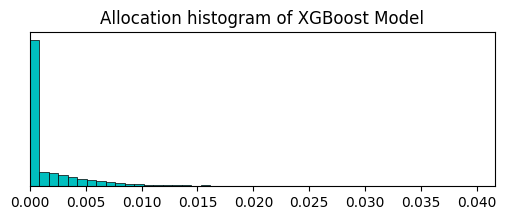

Range of predictions: [0.000000, 0.041575]


In [16]:
# XGBoostモデルで試す
import xgboost as xgb
allocation_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
)

cross_validate(allocation_model, label="XGBoost Model")


=== Fold 0 Test start at 8810 ===


=== Fold 1 Test start at 8630 ===


=== Fold 2 Test start at 8450 ===


=== Fold 3 Test start at 8270 ===


=== Fold 4 Test start at 8090 ===


=== Fold 5 Test start at 7910 ===
=== Fold 6 Test start at 7730 ===
=== Fold 7 Test start at 7550 ===
=== Fold 8 Test start at 7370 ===
=== Fold 9 Test start at 7190 ===
=== Fold 10 Test start at 7010 ===
=== Fold 11 Test start at 6830 ===
=== Fold 12 Test start at 6650 ===
=== Fold 13 Test start at 6470 ===
=== Fold 14 Test start at 6290 ===
=== Fold 15 Test start at 6110 ===
=== Fold 16 Test start at 5930 ===
=== Fold 17 Test start at 5750 ===
=== Fold 18 Test start at 5570 ===
=== Fold 19 Test start at 5390 ===
=== Fold 20 Test start at 5210 ===
=== Fold 21 Test start at 5030 ===
=== Fold 22 Test start at 4850 ===
=== Fold 23 Test start at 4670 ===
=== Fold 24 Test start at 4490 ===
=== Fold 25 Test start at 4310 ===
=== Fold 26 Test start at 4130 ===
=== Fold 27 Test start at 3950 ===
=== Fold 28 Test start at 3770 ===
=== Fold 29 Test start at 3590 ===
=== Fold 30 Test start at 3410 ===


=== Fold 31 Test start at 3230 ===


=== Fold 32 Test start at 3050 ===


=== Fold 33 Test start at 2870 ===


=== Fold 34 Test start at 2690 ===


=== Fold 35 Test start at 2510 ===


=== Fold 36 Test start at 2330 ===


=== Fold 37 Test start at 2150 ===


=== Fold 38 Test start at 1970 ===


=== Fold 39 Test start at 1790 ===


=== Fold 40 Test start at 1610 ===


CatBoost Model Average Validation Score: 0.269278
CatBoost Model Overall Validation Score: 0.128361 vol_penalty=1.00 return_penalty=1.60
CatBoost Model First(Test) Fold Validation Score: 0.147058


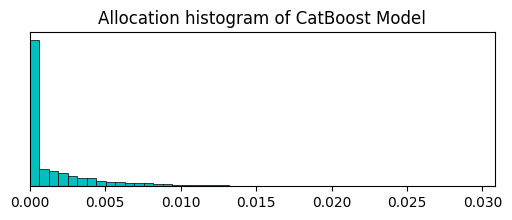

Range of predictions: [0.000000, 0.030810]


In [17]:
# CatBoostモデルで試す
from catboost import CatBoostRegressor
allocation_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=0,
)

cross_validate(allocation_model, label="CatBoost Model")

In [18]:
# Stacking Regressorで試す
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

params_CAT = {
    "iterations": 3000,
    "learning_rate": 0.01,
    "depth": 6,
    "l2_leaf_reg": 5.0,
    "min_child_samples": 100,
    "colsample_bylevel": 0.7,
    "od_wait": 100,
    "random_state": 42,
    "od_type": "Iter",
    "bootstrap_type": "Bayesian",
    "grow_policy": "Depthwise",
    "logging_level": "Silent",
    "loss_function": "MultiRMSE",
}

params_R_Forest = {
    "n_estimators": 100,
    "min_samples_split": 5,
    "max_depth": 15,
    "min_samples_leaf": 3,
    "max_features": "sqrt",
    "random_state": 42,
}

params_Extra = {
    "n_estimators": 100,
    "min_samples_split": 5,
    "max_depth": 12,
    "min_samples_leaf": 3,
    "max_features": "sqrt",
    "random_state": 42,
}

params_XGB = {
    "n_estimators": 1500,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "reg_alpha": 1.0,
    "reg_lambda": 1.0,
    "random_state": 42,
}

params_LGBM = {
    "n_estimators": 1500,
    "learning_rate": 0.05,
    "num_leaves": 50,
    "max_depth": 8,
    "reg_alpha": 1.0,
    "reg_lambda": 1.0,
    "random_state": 42,
    "verbosity": -1,
}

params_DecisionTree = {"criterion": "poisson", "max_depth": 6}

params_GB = {
    "learning_rate": 0.1,
    "min_samples_split": 500,
    "min_samples_leaf": 50,
    "max_depth": 8,
    "max_features": "sqrt",
    "subsample": 0.8,
    "random_state": 10,
}


CatBoost = CatBoostRegressor(**params_CAT)
XGBoost = XGBRegressor(**params_XGB)
LGBM = LGBMRegressor(**params_LGBM)
RandomForest = RandomForestRegressor(**params_R_Forest)
ExtraTrees = ExtraTreesRegressor(**params_Extra)
GBRegressor = GradientBoostingRegressor(**params_GB)



=== Fold 0 Test start at 8810 ===


ValueError: Input X contains NaN.
ExtraTreesRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

=== Fold 0 Test start at 8810 ===


=== Fold 1 Test start at 8630 ===


=== Fold 2 Test start at 8450 ===


=== Fold 3 Test start at 8270 ===


=== Fold 4 Test start at 8090 ===


=== Fold 5 Test start at 7910 ===
=== Fold 6 Test start at 7730 ===
=== Fold 7 Test start at 7550 ===
=== Fold 8 Test start at 7370 ===
=== Fold 9 Test start at 7190 ===
=== Fold 10 Test start at 7010 ===
=== Fold 11 Test start at 6830 ===
=== Fold 12 Test start at 6650 ===
=== Fold 13 Test start at 6470 ===
=== Fold 14 Test start at 6290 ===
=== Fold 15 Test start at 6110 ===
=== Fold 16 Test start at 5930 ===
=== Fold 17 Test start at 5750 ===
=== Fold 18 Test start at 5570 ===
=== Fold 19 Test start at 5390 ===
=== Fold 20 Test start at 5210 ===
=== Fold 21 Test start at 5030 ===
=== Fold 22 Test start at 4850 ===
=== Fold 23 Test start at 4670 ===
=== Fold 24 Test start at 4490 ===
=== Fold 25 Test start at 4310 ===
=== Fold 26 Test start at 4130 ===
=== Fold 27 Test start at 3950 ===
=== Fold 28 Test start at 3770 ===
=== Fold 29 Test start at 3590 ===
=== Fold 30 Test start at 3410 ===


=== Fold 31 Test start at 3230 ===


=== Fold 32 Test start at 3050 ===


=== Fold 33 Test start at 2870 ===


=== Fold 34 Test start at 2690 ===


=== Fold 35 Test start at 2510 ===


=== Fold 36 Test start at 2330 ===


=== Fold 37 Test start at 2150 ===


=== Fold 38 Test start at 1970 ===


=== Fold 39 Test start at 1790 ===


=== Fold 40 Test start at 1610 ===


Stacking Regressor Model Average Validation Score: 0.161702
Stacking Regressor Model Overall Validation Score: 0.023124 vol_penalty=1.00 return_penalty=1.60
Stacking Regressor Model First(Test) Fold Validation Score: 0.241299


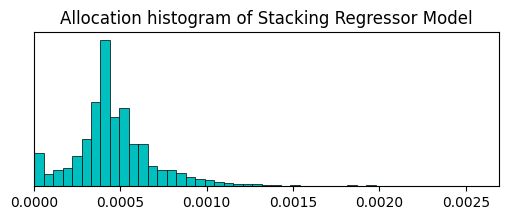

Range of predictions: [0.000000, 0.002693]


In [20]:
# NaNを許容するモデルだけでStacking
# RandomForest, ExtraTrees, CatBoost, XGBoost, LGBM, GBRegressor, RidgeCV
estimators = [
    ('cat', CatBoost),
    ('xgb', XGBoost),
    ('lgbm', LGBM),
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    n_jobs=-1,
    passthrough=False,
)
cross_validate(stacking_model, label="Stacking Regressor Model")

=== Fold 0 Test start at 8810 ===


=== Fold 1 Test start at 8630 ===


=== Fold 2 Test start at 8450 ===


=== Fold 3 Test start at 8270 ===


=== Fold 4 Test start at 8090 ===


=== Fold 5 Test start at 7910 ===
=== Fold 6 Test start at 7730 ===
=== Fold 7 Test start at 7550 ===
=== Fold 8 Test start at 7370 ===
=== Fold 9 Test start at 7190 ===
=== Fold 10 Test start at 7010 ===
=== Fold 11 Test start at 6830 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 12 Test start at 6650 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 13 Test start at 6470 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 14 Test start at 6290 ===
=== Fold 15 Test start at 6110 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 16 Test start at 5930 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 17 Test start at 5750 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 18 Test start at 5570 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'S3' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 19 Test start at 5390 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'S3' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'S3' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'S3' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'S3' 'V10']. At least one non-missing value is needed for imputation with strat

=== Fold 20 Test start at 5210 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'S3' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 21 Test start at 5030 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 22 Test start at 4850 ===
=== Fold 23 Test start at 4670 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10' 'V9']. At least one non-missing

=== Fold 24 Test start at 4490 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 25 Test start at 4310 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 26 Test start at 4130 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 27 Test start at 3950 ===
=== Fold 28 Test start at 3770 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10' 'V9']. At least 

=== Fold 29 Test start at 3590 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S12' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 30 Test start at 3410 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M6' 'S12' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M5' 'M6' 'S12' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 31 Test start at 3230 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M5' 'M6' 'S12' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M5' 'M6' 'S12' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 32 Test start at 3050 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M5' 'M6' 'S12' 'S3' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 33 Test start at 2870 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 34 Test start at 2690 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 35 Test start at 2510 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 36 Test start at 2330 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 37 Test start at 2150 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M3' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 38 Test start at 1970 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M3' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M3' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 39 Test start at 1790 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E7' 'M1' 'M13' 'M14' 'M2' 'M3' 'M5' 'M6' 'S12' 'S3' 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E1' 'E20' 'E7' 'M1' 'M13' 'M14' 'M2' 'M3' 'M5' 'M6' 'P6' 'P7' 'S12' 'S3'
 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== Fold 40 Test start at 1610 ===


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['E1' 'E20' 'E7' 'M1' 'M13' 'M14' 'M2' 'M3' 'M5' 'M6' 'P6' 'P7' 'S12' 'S3'
 'S8' 'V10' 'V9']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Stacking Regressor Model Average Validation Score: 0.178587
Stacking Regressor Model Overall Validation Score: 0.026786 vol_penalty=1.00 return_penalty=1.60
Stacking Regressor Model First(Test) Fold Validation Score: 0.099141


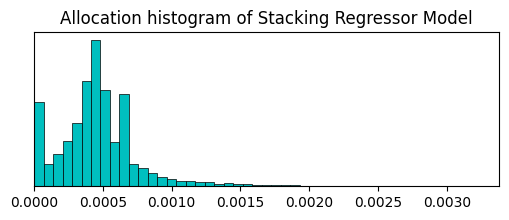

Range of predictions: [0.000000, 0.003379]


In [22]:
# 欠損値を処理するためのSimpleImputerを用いたStackingモデル
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
imputer = SimpleImputer(strategy='median')

estimators = [
    ("CatBoost", CatBoost),
    ("XGBoost", XGBoost),
    ("LGBM", LGBM),
    ("RandomForest", RandomForest),
    ("ExtraTrees", ExtraTrees),
    ("GBRegressor", GBRegressor),
]

model_3 = make_pipeline(
    imputer,
    StackingRegressor(
        estimators,
        final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0]),
        cv=3,
        n_jobs=-1,
        passthrough=False,
    ),
)

cross_validate(model_3, label="Stacking Regressor Model")

#### public solutions:

- [Model 7](#Model_7) - Lb=[17.396](https://www.kaggle.com/code/baidalinadilzhan/hull-tactical-lb-17-396?scriptVersionId=262804590) - v.1 - [hull-tactical-lb-17.396](https://www.kaggle.com/code/baidalinadilzhan/hull-tactical-lb-17-396)
- [Model 6](#Model_6) - Lb=[10.237](https://www.kaggle.com/code/veniaminnelin/hull-tactical-leaderboard-lol?scriptVersionId=262531157) - v.3 - [Hull Tactical - Leaderboard LOL](https://www.kaggle.com/code/veniaminnelin/hull-tactical-leaderboard-lol).2
- [Model 5](#Model_5) - Lb=[10.217](https://www.kaggle.com/code/mbrosseau/hull-tactical-max-leaderboard?scriptVersionId=262493413) - v.9 - [Hull Tactical - Max Leaderboard](https://www.kaggle.com/code/mbrosseau/hull-tactical-max-leaderboard)
- [Model 4](#Model_4) - Lb=[10.164](https://www.kaggle.com/code/mbrosseau/hull-tactical-max-leaderboard?scriptVersionId=262493413) - v.4 - [Hull Tactical - Max Leaderboard](https://www.kaggle.com/code/mbrosseau/hull-tactical-max-leaderboard)
- [Model 1](#Model_1) - Lb=[10.147](https://www.kaggle.com/code/veniaminnelin/hull-tactical-leaderboard-lol?scriptVersionId=262460746) - v.1 - [Hull Tactical - Leaderboard LOL](https://www.kaggle.com/code/veniaminnelin/hull-tactical-leaderboard-lol).1
- [Model 2](#Model_2) - LB=[10.005](https://www.kaggle.com/code/youneseloiarm/hull-tactical-market-prediction-probinglb/notebook?scriptVersionId=262450829) - v.4 - [Hull Tactical - Market Prediction - ProbingLB
  ](https://www.kaggle.com/code/youneseloiarm/hull-tactical-market-prediction-probinglb)
- [Model 3](#Model_3) - LB=[ &nbsp;8.093](https://www.kaggle.com/code/imaadmahmood/hull-market-prediction?scriptVersionId=262297550) - v.4 - [Hull Market Prediction
  ](https://www.kaggle.com/code/imaadmahmood/hull-market-predictionb)


In [ ]:
import kaggle_evaluation.default_inference_server

## Model_1


Since in this competition the leaderboard does not really matter, as all test data is included in the training set, I was simply curious to see what the maximum possible score of the metric could be if we had perfect knowledge of the "future" market behavior, and to better understand how the evaluation metric works.

(And it was also fun to get to the first position on the leaderboard at least once in my life, even if only for a short while =)


In [ ]:
# 真値をそのまま持ってくるチートモデルを定義し，スコアの最大値を確認する
class CheatModel:
    def fit(self, X, y):
        pass

    def predict(self, X):
        indices = X.index
        try:
            true_returns = train.loc[indices, "forward_returns"].to_numpy()
        except KeyError:
            raise KeyError("CheatModel can only be used on training data.")

        return true_returns
    
cross_validate(CheatModel(), label="Cheat Model")

In [ ]:
# 単純なLightGBMによって評価


## Model_3


In [ ]:
import os

from sklearn.linear_model import RidgeCV

import pandas as pd, polars as pl, numpy as np

from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split


train = pd.read_csv(DATA_PATH / "train.csv").dropna()
test = pd.read_csv(DATA_PATH / "test.csv").dropna()


def preprocessing(data, typ):
    main_feature = [
        "E1",
        "E2",
        "E3",
        "E4",
        "E5",
        "E6",
        "E7",
        "E8",
        "E9",
        "E10",
        "E11",
        "E12",
        "E13",
        "E14",
        "E15",
        "E16",
        "E17",
        "E18",
        "E19",
        "E20",
        "I2",
        "P8",
        "P9",
        "P10",
        "P12",
        "P13",
        "S1",
        "S2",
        "S5",
    ]

    if typ == "train":
        data = data[main_feature + ["forward_returns"]]
    else:
        data = data[main_feature]

    for i in zip(data.columns, data.dtypes):
        data[i[0]].fillna(0, inplace=True)

    return data


train = preprocessing(train, "train")

train_split, val_split = train_test_split(train, test_size=0.01, random_state=4)

X_train = train_split.drop(columns=["forward_returns"])
X_test = val_split.drop(columns=["forward_returns"])

y_train = train_split["forward_returns"]
y_test = val_split["forward_returns"]

params_CAT = {
    "iterations": 3000,
    "learning_rate": 0.01,
    "depth": 6,
    "l2_leaf_reg": 5.0,
    "min_child_samples": 100,
    "colsample_bylevel": 0.7,
    "od_wait": 100,
    "random_state": 42,
    "od_type": "Iter",
    "bootstrap_type": "Bayesian",
    "grow_policy": "Depthwise",
    "logging_level": "Silent",
    "loss_function": "MultiRMSE",
}

params_R_Forest = {
    "n_estimators": 100,
    "min_samples_split": 5,
    "max_depth": 15,
    "min_samples_leaf": 3,
    "max_features": "sqrt",
    "random_state": 42,
}

params_Extra = {
    "n_estimators": 100,
    "min_samples_split": 5,
    "max_depth": 12,
    "min_samples_leaf": 3,
    "max_features": "sqrt",
    "random_state": 42,
}

params_XGB = {
    "n_estimators": 1500,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "reg_alpha": 1.0,
    "reg_lambda": 1.0,
    "random_state": 42,
}

params_LGBM = {
    "n_estimators": 1500,
    "learning_rate": 0.05,
    "num_leaves": 50,
    "max_depth": 8,
    "reg_alpha": 1.0,
    "reg_lambda": 1.0,
    "random_state": 42,
    "verbosity": -1,
}

params_DecisionTree = {"criterion": "poisson", "max_depth": 6}

params_GB = {
    "learning_rate": 0.1,
    "min_samples_split": 500,
    "min_samples_leaf": 50,
    "max_depth": 8,
    "max_features": "sqrt",
    "subsample": 0.8,
    "random_state": 10,
}

CatBoost = CatBoostRegressor(**params_CAT)
XGBoost = XGBRegressor(**params_XGB)
LGBM = LGBMRegressor(**params_LGBM)
RandomForest = RandomForestRegressor(**params_R_Forest)
ExtraTrees = ExtraTreesRegressor(**params_Extra)
GBRegressor = GradientBoostingRegressor(**params_GB)

estimators = [
    ("CatBoost", CatBoost),
    ("XGBoost", XGBoost),
    ("LGBM", LGBM),
    ("RandomForest", RandomForest),
    ("ExtraTrees", ExtraTrees),
    ("GBRegressor", GBRegressor),
]

model_3 = StackingRegressor(
    estimators, final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0]), cv=3
)

model_3.fit(X_train, y_train)

In [ ]:
def predict_Model_3(test: pl.DataFrame) -> float:
    test = test.to_pandas().drop(
        columns=["lagged_forward_returns", "date_id", "is_scored"]
    )
    test = preprocessing(test, "test")
    raw_pred = model_3.predict(test)[0]
    return raw_pred

## Model_2


In [ ]:
import os
from pathlib import Path
import datetime
from tqdm import tqdm
from dataclasses import dataclass, asdict
import polars as pl
import numpy as np
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
train = pl.read_csv(DATA_PATH / "train.csv")
display(train)
test = pl.read_csv(DATA_PATH / "test.csv")
display(test)

In [ ]:
MIN_SIGNAL: float = 0.0  # Minimum value for the daily signal
MAX_SIGNAL: float = 2.0  # Maximum value for the daily signal
SIGNAL_MULTIPLIER: float = (
    400.0  # Multiplier of the OLS market forward excess returns predictions to signal
)

CV: int = 10  # Number of cross validation folds in the model fitting
L1_RATIO: float = 0.5  # ElasticNet mixing parameter
ALPHAS: np.ndarray = np.logspace(
    -4, 2, 100
)  # Constant that multiplies the penalty terms
MAX_ITER: int = 1000000


@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float
    min_signal: float = MIN_SIGNAL
    max_signal: float = MAX_SIGNAL


ret_signal_params = RetToSignalParameters(signal_multiplier=SIGNAL_MULTIPLIER)

In [ ]:
def predict_Model_2(test: pl.DataFrame) -> float:
    def convert_ret_to_signal(
        ret_arr: np.ndarray, params: RetToSignalParameters
    ) -> np.ndarray:
        return np.clip(
            ret_arr * params.signal_multiplier + 1, params.min_signal, params.max_signal
        )

    global train
    test = test.rename({"lagged_forward_returns": "target"})
    date_id = test.select("date_id").to_series()[0]
    print(date_id)
    raw_pred: float = (
        train.filter(pl.col("date_id") == date_id)
        .select(["market_forward_excess_returns"])
        .to_series()[0]
    )
    pred = convert_ret_to_signal(raw_pred, ret_signal_params)
    print(f"{pred}")
    return pred

## Model_4


In [ ]:
import os
from pathlib import Path
import numpy as np
import polars as pl


# Bounds
MIN_INVESTMENT = 0.0
MAX_INVESTMENT = 2.0

# Load truth for all date_ids
train_m4 = pl.read_csv(DATA_PATH / "train.csv", infer_schema_length=0).select(
    [pl.col("date_id").cast(pl.Int64), pl.col("forward_returns").cast(pl.Float64)]
)
date_ids_m4 = np.array(train_m4["date_id"].to_list(), dtype=np.int64)
rets_m4 = np.array(train_m4["forward_returns"].to_list(), dtype=np.float64)

true_targets4 = dict(zip(date_ids_m4.tolist(), rets_m4.tolist()))

# ---- Fixed best parameter from optimization ----
ALPHA_BEST_m4 = 0.80007  # exposure on positive days


def exposure_for_m4(r: float) -> float:
    if r <= 0.0:
        return 0.0
    return ALPHA_BEST_m4

In [ ]:
def predict_Model_4(test: pl.DataFrame) -> float:
    date_id = int(test.select("date_id").to_series().item())
    r = true_targets.get(date_id, None)
    if r is None:
        return 0.0
    return float(np.clip(exposure_for_m4(r), MIN_INVESTMENT, MAX_INVESTMENT))

## Model_5


### Hull Tactical Market Prediction – Public LB Maximization

> ⚠️ **Important Note:** The public leaderboard in this competition does **not** matter.  
> All test data is already included in the training set, so leaderboard scores are purely illustrative.  
> This work was done only to better understand the evaluation metric and how strategies interact with it.

---

#### TLDR

**Evaluation metric:** Adjusted Sharpe — maximize mean excess return, penalized only if

- strategy volatility > 1.2× market, or
- strategy underperforms the market.  
  → Optimal strategies sit just below the 1.2× vol cap.

**What’s useful:**

- **Vol targeting:** scale exposures so strategy volatility ≈ 1.199× market.
- **Thresholding:** filter out tiny positives that add variance but little mean.
- **Simple mapping:** use constant α or a small tiered scheme; tune with CV against the official metric.

**What’s not useful:**

- Public LB “perfect foresight” scores — these exploit leakage and don’t matter for the actual competition.

---

#### Initial Approach

The starting strategy was the “perfect foresight” method, inspired by Veniamin Nelin’s excellent notebook:

- **Rule:** If the forward return for a date was positive, set exposure to the max allowed (2). Otherwise, set exposure to the min (0).
- **Effect:** Always fully invested on up days and completely out on down days.
- **Result:** Produced a strong adjusted Sharpe (~**10.147**) on the public leaderboard.

---

#### Intermediate Exploration

We next experimented with magnitude-aware scaling:

- **Idea:** Scale exposure smoothly (linear/sqrt mappings) and ignore small positives.
- **Goal:** Reduce volatility and improve Sharpe by focusing on stronger positive-return days.
- **Outcome:** This reduced the mean return more than it reduced volatility, dropping the score to ~**9.77**.

---

#### Key Insight from the Metric

Looking closely at the evaluation code revealed:

- A **volatility penalty** only applies if strategy vol > 1.2× the market’s.
- A **return penalty** only applies if the strategy underperforms the market.
- Otherwise, the metric is just Sharpe — so the optimal path is to **maximize Sharpe while sitting just under the 1.2× cap**.

---

#### Refined Approach

The adjustment was to use the entire volatility budget:

- **Binary tuning:** Instead of always using 2.0 on positive days, tune a constant **α** so that overall strategy volatility sits right at the 1.2× cap.
- **Two-level refinement:** Apply full 2.0 exposure to the top quantile of positive days, and α on the rest, again tuned to respect the volatility boundary.
- **Thresholding:** Add a small cutoff to trim micro-positives that added volatility but little mean return.

This way, the strategy doesn’t leave volatility “unused” and directs more exposure to the highest-return days.

---

#### Results

- **Original binary rule:** ~10.147
- **Magnitude scaling (failed):** ~9.77
- **Two-level refinement:** ~10.164
- **Threshold-tuned single-level:** **10.204**

---

#### Takeaways

- The initial “all-in on positive days, out on negative days” approach is already highly effective under the competition’s rules.
- Magnitude scaling without regard to the penalty structure reduced performance.
- Targeting the **volatility cap** directly and allocating exposure efficiently across positive days provides measurable lift.
- With careful tuning, we pushed the public LB score to **10.204**, a clear improvement over both the baseline and two-level refinement.
- **Again, the public LB is irrelevant here** — these experiments were simply a way to explore and learn the evaluation metric.

---

#### Acknowledgment

Special thanks to **Veniamin Nelin** for the original notebook and inspiration. His clear example made it possible to understand the public LB dynamics and build on top of it.


In [ ]:
import os
from pathlib import Path
import numpy as np
import polars as pl


# Bounds
MIN_INVESTMENT = 0.0
MAX_INVESTMENT = 2.0

# Load truth for all date_ids
train_m5 = pl.read_csv(DATA_PATH / "train.csv", infer_schema_length=0).select(
    [pl.col("date_id").cast(pl.Int64), pl.col("forward_returns").cast(pl.Float64)]
)
date_ids_m5 = np.array(train_m5["date_id"].to_list(), dtype=np.int64)
rets_m5 = np.array(train_m5["forward_returns"].to_list(), dtype=np.float64)

true_targets_m5 = dict(zip(date_ids_m5.tolist(), rets_m5.tolist()))

# ---- Best parameters from Optuna ----
ALPHA_BEST_m5 = 0.6001322487531852
USE_EXCESS_m5 = False
TAU_ABS_m5 = 9.437170708744412e-05  # ≈ 0.01%


def exposure_for_m5(r: float, rf: float = 0.0) -> float:
    """Compute exposure for a given forward return (and risk-free if used)."""
    signal = (r - rf) if USE_EXCESS_m5 else r
    if signal <= TAU_ABS_m5:
        return 0.0
    return ALPHA_BEST_m5

In [ ]:
def predict_Model_5(test: pl.DataFrame) -> float:
    date_id = int(test.select("date_id").to_series().item())
    r = true_targets_m5.get(date_id, None)
    if r is None:
        return 0.0
    return float(np.clip(exposure_for_m5(r), MIN_INVESTMENT, MAX_INVESTMENT))

## Model_6


Since in this competition the leaderboard does not really matter, as all test data is included in the training set, I was simply curious to see what the maximum possible score of the metric could be if we had perfect knowledge of the "future" market behavior, and to better understand how the evaluation metric works.

---

(And it was also fun to get to the first position on the leaderboard at least once in my life, even if only for a short while =)

---

Update: Actually, with a fixed strategy (which also knows future prices), the best I’ve found is to skip on the loss-making days and, on the profitable ones, return a stake of about 0.1 (I clarified this in the new version).

I think the strategy can be improved into something more flexible, but I haven’t figured out how to do that yet.

If this problem could be solved, then for achieving a perfect result only one tiny detail would remain — fully predicting the behavior of the market 😂


In [ ]:
import os
import pandas as pd
import polars as pl
from pathlib import Path


_true_train_df = pl.read_csv(DATA_PATH / "train.csv").select(
    ["date_id", "forward_returns"]
)

true_targets_M6 = {
    int(d): float(v)
    for d, v in zip(
        _true_train_df["date_id"].to_numpy(),
        _true_train_df["forward_returns"].to_numpy(),
    )
}


def predict_Model_6(test: pl.DataFrame) -> float:
    date_id = int(test.select("date_id").to_series().item())
    t = true_targets_M6.get(date_id, None)
    return 0.09 if t > 0 else 0.0

## Model_7


In [ ]:
import os
from gc import collect
from tqdm.notebook import tqdm
from scipy.optimize import minimize, Bounds
import pandas as pd, numpy as np, polars as pl
from warnings import filterwarnings

filterwarnings("ignore")

In [ ]:
%%time 

MIN_INVESTMENT = 0
MAX_INVESTMENT = 2


class ParticipantVisibleError(Exception):
    pass


def ScoreMetric(
    solution: pd.DataFrame, 
    submission: pd.DataFrame, 
    row_id_column_name: str
) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).
    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.
    Returns: The calculated adjusted Sharpe ratio.
    """
    solut = solution
    solut['position'] = submission['prediction']

    if solut['position'].max() > MAX_INVESTMENT:
        raise ParticipantVisibleError(
            f'Position of {solut["position"].max()} exceeds maximum of {MAX_INVESTMENT}')
        
    if solut['position'].min() < MIN_INVESTMENT:
        raise ParticipantVisibleError(
            f'Position of {solut["position"].min()} below minimum of {MIN_INVESTMENT}')

    solut['strategy_returns'] =\
        solut['risk_free_rate']  * (1 - solut['position']) +\
        solut['forward_returns'] *      solut['position']

    # Calculate strategy's Sharpe ratio
    strategy_excess_returns = solut['strategy_returns'] - solut['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solut)) - 1
    strategy_std = solut['strategy_returns'].std()

    trading_days_per_yr = 252
    if strategy_std == 0:
        raise ZeroDivisionError
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate market return and volatility
    market_excess_returns = solut['forward_returns'] - solut['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solut)) - 1
    market_std = solut['forward_returns'].std()

    
    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)

    
    # Calculate the volatility penalty
    excess_vol =\
        max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0

    
    vol_penalty = 1 + excess_vol
    

    # Calculate the return penalty
    return_gap =\
        max(0, (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr)

    
    return_penalty = 1 + (return_gap**2) / 100

    # Adjust the Sharpe ratio by the volatility and return penalty
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    
    return min(float(adjusted_sharpe), 1_000_000)

In [ ]:
# Source - https://www.kaggle.com/competitions/hull-tactical-market-prediction/discussion/608349

tM7 = pd.read_csv(DATA_PATH / "train.csv", index_col="date_id")


def fun(x):
    solution = tM7[-180:].copy()
    submission = pd.DataFrame({"prediction": x.clip(0, 2)}, index=solution.index)
    return -ScoreMetric(solution, submission, "")


x0 = np.full(180, 0.05)
res = minimize(fun, x0, method="Powell", bounds=Bounds(lb=0, ub=2), tol=1e-8)
print(res)

opt_preds, i_M7 = res.x, 0

In [ ]:
def predict_Model_7(test: pl.DataFrame) -> float:

    global i_M7, opt_preds

    pred = np.float64(opt_preds[i_M7])

    print(f"---> {pred:,.8f} | Iteration {i_M7}")

    i_M7 = i_M7 + 1

    return pred

## ensemble


In [ ]:
def predict(test: pl.DataFrame) -> float:

    pred_7 = predict_Model_7(test)  # 17.396
    pred_6 = predict_Model_6(test)  # 10.237
    pred_5 = predict_Model_5(test)  # 10.217
    pred_4 = predict_Model_4(test)  # 10.164
    pred_1 = predict_Model_1(test)  # 10.147
    pred_2 = predict_Model_2(test)  #  8.093
    pred_3 = predict_Model_3(test)  #  ?

    pred = pred_1 * 0.55 + 0.45 * pred_2  # 10.078
    pred = pred_1 * 0.70 + 0.30 * pred_2  # 10.101

    # LB = 17.300
    pred = (
        pred_7 * 0.9850
        + pred_6 * 0.0100
        + pred_5 * 0.0030
        + pred_4 * 0.0010
        + pred_1 * 0.0007
        + pred_2 * 0.0003
    )

    # LB = 17.373
    pred = (
        pred_7 * 0.9927
        + pred_6 * 0.0050
        + pred_5 * 0.0015
        + pred_4 * 0.0005
        + pred_1 * 0.0002
        + pred_2 * 0.0001
    )

    # LB = 17.387
    pred = (
        pred_7 * 0.9959
        + pred_6 * 0.0025
        + pred_5 * 0.0012
        + pred_4 * 0.0003
        + pred_1 * 0.0001
        + pred_2 * 0.0000
    )

    # LB = 17.362
    pred = (
        pred_7 * 0.9974
        + pred_6 * 0.0005
        + pred_5 * 0.0005
        + pred_4 * 0.0005
        + pred_1 * 0.0005
        + pred_2 * 0.0006
    )

    # LB = 17.392
    pred = (
        pred_7 * 0.9990
        + pred_6 * 0.0003
        + pred_5 * 0.0002
        + pred_4 * 0.0002
        + pred_1 * 0.0002
        + pred_2 * 0.0001
    )

    # LB = 17.396
    pred = (
        pred_7 * 0.99974
        + pred_6 * 0.00013
        + pred_5 * 0.00005
        + pred_4 * 0.00004
        + pred_1 * 0.00003
        + pred_2 * 0.00001
    )

    # LB = 17.396
    pred = (
        pred_7 * 0.90300
        + pred_6 * 0.02700
        + pred_5 * 0.01900
        + pred_4 * 0.01700
        + pred_1 * 0.01300
        + pred_2 * 0.01200
        + pred_3 * 0.00900
    )

    # LB = ?
    pred = (
        pred_7 * 1.00021
        - pred_6 * 0.00006
        - pred_5 * 0.00005
        - pred_4 * 0.00004
        - pred_1 * 0.00003
        - pred_2 * 0.00002
        - pred_3 * 0.00001
    )

    return pred

## inference


In [ ]:
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(
    predict
)

if os.getenv("KAGGLE_IS_COMPETITION_RERUN"):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        ("/kaggle/input/hull-tactical-market-prediction/",)
    )